In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'itba-cifar-100-2024-q-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77584%2F8490010%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T132957Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06092b953b3de4f6820aee4b35371398e41b44a3b425ef580339cff26e1b848dc594c43a5c5f57c84829321998b04dbc075d39f450905fbbe6d52a52a8d00c3a8af5648ba9fed8ad129653d9aadf916b9992c8f2c84a28ec5e12ea9770c8c611d62093c06ae1092a5d8ac349991d409717e1d742b9962d05fc498189152488f04341830ea76831b12d1291ba52602ffcbef53613d5f832436c4d39f9f970ee45fe536d925c125dc05390919aefe7234023703db958e16556d0ef6724dbe13be8c52c828b5f077fb69474887b519a0b66334352f412d4c098da9d04106c68eed6290b5b3e898d60b5d9174c03c3c6a9b332bc8898a432909018fe996a97b5d3fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 168426762 bytes downloaded
Downloaded and uncompressed: itba-cifar-100-2024-q-1
Data source import complete.


#EDA


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck


In [ ]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")
print(y_train_coarse)
print(y_train_fine)

[11 15  4 ...  8  7  1]
[19 29  0 ...  3  7 73]


In [ ]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [ ]:
from matplotlib import pyplot as plt
#%load_ext tensorboard

[19 29  0 ...  3  7 73]


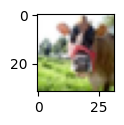

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[0])

print(y_train_fine)

In [ ]:
y_train_fine[0]

19

In [ ]:
labels_fine[19]

'cattle'

#Cross Validation

De todo el dataset de train se dividió un 20% para poder realizar el cross validation.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_train_cv, y_train, y_train_cv = train_test_split(np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.,
                                                    y_train_fine, test_size=0.2, random_state=42)

In [ ]:
#Chequeamos que los tamaños son los esperados
print(len(X_train))
print(len(X_train_cv))
print(len(y_train))
print(len(y_train_cv))

40000
10000
40000
10000


###Extensión del dataset con Data Generator

In [ ]:
#Se requiere extender el dataset, se utiliza un generator donde se rotan y se cambian las imágenes.Esto nos permite entrenar con más imágenes que tienen información del dataset y
#y que no son iguales a las generales.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,  #tengo que flipearlas horizontalmente, no verticalmente
    zoom_range=0.2,
    shear_range=0.15
)
datagen.fit(X_train)




#Armado de la red




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from  tensorflow.keras.optimizers.schedules import InverseTimeDecay

In [ ]:
#esto su utilizó como prueba, pero al final fue preferible el Rlop
#la diferencia es que esto va cambiando paso más cortos en el tiempo de entrenamiento. No espera como ReduceLROnPlateau a cierta cantidad de iteraciones donde no cambia el accuracy
lr_schedule =InverseTimeDecay(
    0.001,
    decay_steps=1875*100,
    decay_rate=5,
    staircase=False
)

##Glorot Uniform

In [ ]:
#inicializador, se corrió con uniforme y normal y se tomó el de mejor funcionamiento
#Kernel initialiazer
initializer = GlorotUniform()
initializer_normal = GlorotNormal()

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(32,32,3)))


#En la activación se usó swish en vez de relu debido a que brindó mejores resultados (un 2-3% aproximado de mejora)
#First layer
model.add(Dense(1024, activation="swish", kernel_initializer = initializer))
model.add(Dropout(0.2))

#second layer
model.add(Dense(512, activation="swish", kernel_initializer = initializer))
model.add(BatchNormalization())

#thrid layer
model.add(Dense(256, activation="swish", kernel_initializer = initializer))
model.add(Dropout(0.2))

#fourth layer
model.add(Dense(100, activation="softmax",kernel_initializer = initializer))

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


##Callbacks del modelo
Se utilizó:


*   ReduceLROnPlateau: permite disminuir el learning rate si la métrica no cambia. En este caso la métrica es val_accurracy. En este caso empieza el entrenamiento con 0.001 de learning rate y cada 3 Epoch donde no mejora la métrica, baja en una factor de 0.25 hasta llegar al mínimo.
*  ModelCheckpoint: me permite guardar los pesos de la mejor métrica
*  EarlyStopping: termina el modelo así no se genera overfitting en el caso de que la métrica no haya mejorado en una cantidad de 8 epoch seguidos



In [ ]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.25,
    patience = 3,
    verbose = 1,
    min_lr = 0.5e-5
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              3146752   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                      

In [ ]:
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8,
    verbose = 1,
    restore_best_weights = True,
)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)


#Entrenamiento


In [ ]:
history = model.fit(
#     x = X_train_flip,
#     y= Y_train_fine_flip,
    datagen.flow(X_train, y_train, batch_size=64),
    batch_size=64,
    epochs=100,
    validation_data =(X_train_cv, y_train_cv),
    callbacks= [
        rlrop,
        es,
        mc,
        tb,
    ]
)

Epoch 1/100
624/625 [============================>.] - ETA: 0s - loss: 4.1799 - accuracy: 0.0705
Epoch 1: val_accuracy improved from -inf to 0.08780, saving model to best.weights.h5
625/625 [==============================] - 25s 36ms/step - loss: 4.1793 - accuracy: 0.0706 - val_loss: 3.9806 - val_accuracy: 0.0878 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 3.8098 - accuracy: 0.1143
Epoch 2: val_accuracy improved from 0.08780 to 0.13730, saving model to best.weights.h5
625/625 [==============================] - 23s 37ms/step - loss: 3.8098 - accuracy: 0.1143 - val_loss: 3.7179 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 3.6735 - accuracy: 0.1370
Epoch 3: val_accuracy improved from 0.13730 to 0.14510, saving model to best.weights.h5
625/625 [==============================] - 23s 36ms/step - loss: 3.6735 - accuracy: 0.1370 - val_loss: 3.6374 - val_accuracy: 0.1451 - lr: 0.0010
Epoch 4/10

#Resultados


Para un kernel con distribución normal dió un accuracy mejor en el kaggle, pero en val_accuracy casi igual. Dejo los dos csv por las dudas, pero este fue el de mejor resultado.
En test se obtuvo un accuracy del 29%.

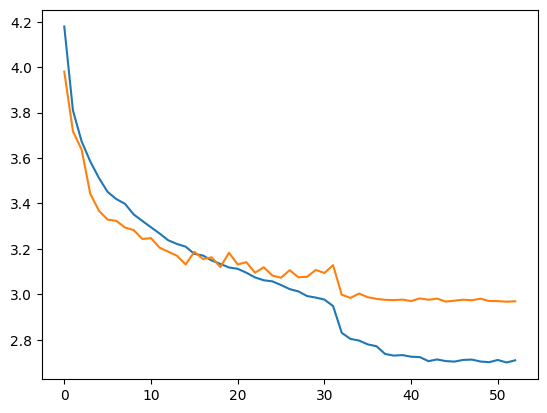

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])


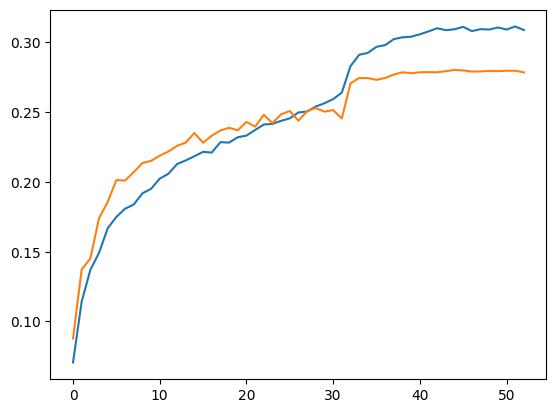

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
predictions = model.predict(x_test)

#test_accuracy_prom=sum(np.array(predictions)==np.array(x_test[\"target\"]))/len(twenty_test[\"target\"])*100\n))

313/313 [==============================] - 1s 2ms/step


In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
predictions

array([71, 66, 15, ..., 51, 80,  0])

In [ ]:
df = pd.DataFrame(predictions, columns=["Label"])

In [ ]:
df.index.name = "Id"

In [ ]:
df.head()

,Label
Id,
0,71
1,66
2,15
3,11
4,71


In [ ]:
df.to_csv("submission.csv")